# Ozone project - Polar Ozone Responses to Volcanic Eruprions


**Student:**
Sigrid Marie Vildskog Auganæs, University of Oslo (smaugana@uio.no)

**Date:** ...

**Assistant:** Zhihong Zhuo

### **Abstract**

Volcanic eruptions can influence many things within the earth system. Ozone is a naturally occurring gas in the atmosphere with an important role in life on earth. The gases and aerosols emitted during a volcanic eruption can affect the ozone concentration. By properly modeling past vulcanic eruptions and the earth systems responses, we may know more about the consequenses of  posible upcoming vulcanic eruption. Using past eruptions as refrence, one can make earth system models like NorEMS better at calculating the systems response to volcanic eruptions. This study focuses on investigating different ozone responses to volcanic eruptions in different background atmosphere conditions. For investigating this, we adopted three different experimental runs of NorESM. It can be a difficult task to identify any ozone response from total ozone column data averaged globaly or above the polar regions. However, NorESM shows an ozone response in monthly anomalies especially over the northern polar region for both pre-CFC and present-day atmosphere concentrations when considering only the the models ozone maximum layer. During pre-CFC there is a positive ozone response, though a model run without vulcanic forcing is needed to make a better assessment. Present-day ozone response to vulcanic eruptions is presumably negative.


### **Table of Contents**

- 1.0 Introduction
- 2.0 Methods
    - 2.1 Importing Packages
    - 2.2 accessing data from bucket
    - 2.3 Analysis method
    - 2.4 Model method
- 3.0 Results and discussion
- 4.0 Conclusion
- 5.0 Refrences

### __1.0 Introduction__

Vulcanic eruptions release both gasses and aerosol particles into the atmosphere. If these compounds reach et stratosphere they can form particles that reflect incoming shortwave solar radiation, or absorb longwave radiation which can cool the surface and warm the stratosphere. Stratospheric vulcanic aerosols can also disturb the ozone concentration, by providing a surface on which heterogeneous ozone-depleating reactions can take place in the prenence of ChloroFluouCarbons (CFCs) in Polar Stratospheric Clouds (PSCs). There is therefore assumed to be a different ozone respons during the era pre-CFC compared to atropogenic conditions.

To investigate the ozone response in a model, one volcanic eruptions in each condition is chosen. The volcanic eruptions chosen for this study in the eruption of Krakatoa in 1883, and Mt. Pinatubo in 1991. The reason why these specific eruptions was chosen is a combination of different factors as geographicagl location, size and explosiveness, and timing of the eruptions. Both eruptions are located in the tropics close to the equator, and both eruptions are on the list of the biggest vulcanic eruptions recorded. 


Three different experimental runs of NorESM will be used to study the response of ozone to volcanic eruptions. Two of the runs cover the atropogenic eruption of Mt. Pinatubo, and the third cover the eruption of Krakatoa in pre-CFC conditions. 


This study intends to investigate the arctic ozone response to vulcanic eruptions in NorESM, and the difference between present-day and pre-CFC conditions. 


The research questions are: 
- How does ozone respond to vulcanic eruptions in NorESM? 
- Is there a difference in ozone response between present-day and pre-CFC atmospheres?

The hypohesis is:
- Ozone consentration will increase as a respons to a vulcanic eruption in pre-CFC.
- Ozone consentration will decrease as a respons to a vulcanic eruption in present-day.

### **2.0 Methods**

#### 2.1 Importing packages

In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
%matplotlib inline

from Sigrid_funktions import *

#### 2.2 Model method

In [2]:
# Accessing data from bucket
import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [3]:
#List of files and variables

#Present day, Pinatubo 
#From experiment 14
#Columb O3
o3_cb_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/cb_O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Temperature
t_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/T.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Columb Sulfate
so4_cb_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/cb_SULFATE.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#AOD sulfate 
aod_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/D550_SO4.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Ozone layers
o3_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Sulfate in layers
so4_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/mmr_SULFATE.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#SO2
so2_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/SO2.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'

#From experiment 16
#Columb O3
o3_cb_16 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16/cb_O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16.cam.h0.197001-201412.nc'
#Ozone layers
o3_16 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16/O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16.cam.h0.197001-201412.nc'


#Pre-CFC's, Krakatao
#Columb O3
o3_cb_pre = 's3://escience2022/Zhihong/NHISTvsls/cb_O3.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#AOD sulfate
aod_pre = 's3://escience2022/Zhihong/NHISTvsls/D550_SO4.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#Sulfate in layers
so4_pre = 's3://escience2022/Zhihong/NHISTvsls/mmr_SULFATE.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#O3 in layers
o3_pre = 's3://escience2022/Zhihong/NHISTvsls/O3.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'


The model used in this study is the high-resolution variant of the second version if the Norwegian Earth System Model (NorEMS2 MM). This model has 32 vertical layers with a model top at 3.6 hPa. The horizontal resolution is 1 degree for all model components. It is a coupled model based on the second version of the Community Earth System Model (CESM2).

The three different model runs used in this study are all administrated by Dirk Olivie at Met Norway. Two of the experimental model runs used in this study for covering the present-day period have prescribed SST, and different settings for vulcanic forcing. Experiment 14 is run with 90% SO2 and 10% SO4 injection for the vulcanic eruptions, while experiment 16 has no injection and is therefore without vulcanic forcing. Experimental runs 14 and 16 are available from 1970 to 2014, capturing the Mt. Pinatubo eruption. The third experiment is to cover the pre-CFC period from 1850 to 1899, capturing Krakatoa with vulcanic forcing. 

The atmospheric chemistry in NorESM 2 MM has 17 different heterogeneous reactions which play an important role in ozone depletion in relation to PSC's.


#### 2.3 Analysis method

Converting units to Dobson units, which is the standard for total ozone column. https://sacs.aeronomie.be/info/dobson.php

In [ ]:
ds2=do16['cb_O3']/(2.1415*(10**(-5)))

##### 2.3.1 Weighted means

In [4]:
def computeWeightedMean(data):
    # Compute weights based on the xarray
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    # Compute weighted mean
    air_weighted = data.weighted(weights)
    weighted_mean = air_weighted.mean(("lon", "lat"))
    return weighted_mean

##### 2.3.2 Anomalies and climatologies

In [5]:
def calc_monthly_anomaly(data,end_prior_eruption):
    start = data.time[0].values
    end_prior_eruption = cftime.DatetimeNoLeap(end_prior_eruption,1,15)
    ds_post_eruption = data
    ds_climatology = data.sel(time=slice(start,end_prior_eruption)).groupby('time.month').mean('time', keep_attrs=True)
    ds_anomaly = ds_post_eruption.groupby('time.month') - ds_climatology
    ds_anomaly.attrs = ds_climatology.attrs
    return ds_anomaly

##### 2.3.3 Time periods

In [6]:
#Pinatubo
start_pina = cftime.DatetimeNoLeap(1985,1,15)
end_prior_eruption_pina = cftime.DatetimeNoLeap(1991,1,15)
end_pina = cftime.DatetimeNoLeap(1996,1,15)

#Krakatao
start_krak = cftime.DatetimeNoLeap(1878,1,15)
end_prior_eruption_krak = cftime.DatetimeNoLeap(1882,1,15)
end_krak = cftime.DatetimeNoLeap(1887,1,15)

The time period of interes ranges from 5 years before to 5 years after each eruption. This is because a climatology wil be calculated using the 5 last years before the eruption, excluding the eruption yerar, to properly assess whether the eruption year and the following years differ from the climatology.

### **3.0 Results and Discussion**

In [7]:
da = xr.open_dataset(s3.open(aod_14))
dp = da['D550_SO4']

db = xr.open_dataset(s3.open(aod_pre))
dk = db['D550_SO4']

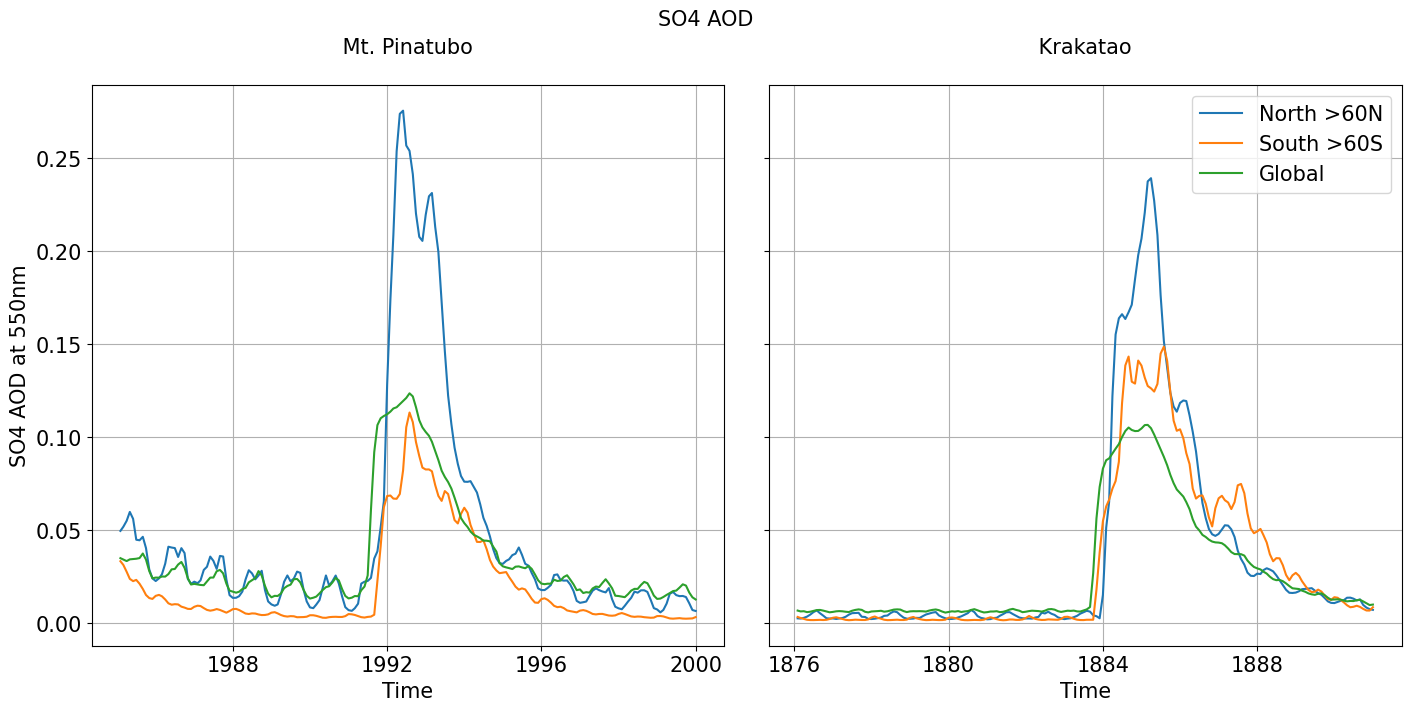

In [8]:
forcing_plot(dp,dk)

Figure 1: SO4 AOD peak for the two vulcanic eruprions of interest. Mt. Pinatubo erupted in june 1991, Krakatoa erupted in May 1883. For Mt. Pinatubo only the experiment with vulcanic forcing is shown. 

Figure one shows that for both vulcanic erruptions the peak in SO4 AOD is about a year delayed from the erruption time. The values are also much higher for the northern polar region, probably due to the general circulation of the atmosphere bringing the particles north with the Brewer Dobson circulation. Spacial plot of the monthly development of SO4 AOD can be seen (on figure from suplement, spacial plot). Wether or not the NorESM resolves the brewer dobson circulation due to its low model top and coarse resolution is a whole reseach topic on its own, but at least the model appares to represent it.

Further, the northern polar region is chosen for further study due to the majority of the signal being over this region. 

In [9]:
dso4_14= xr.open_dataset(s3.open(so4_14))
dso4_14.time.values;
ds_so4_14=dso4_14['mmr_SULFATE']

dso4_pre= xr.open_dataset(s3.open(so4_pre))
dso4_pre.time.values;
ds_so4_pre=dso4_pre['mmr_SULFATE']

In [10]:
ds_so4_14.mean('lon')
ds_so4_pre.mean('lon')
north_avrg_14 = computeWeightedMean(ds_so4_14.where(ds_so4_14['lat']>60.)).compute()
north_avrg_pre = computeWeightedMean(ds_so4_pre.where(ds_so4_pre['lat']>60.)).compute()
dso4_s_14 = north_avrg_14.sel(time=slice(start_pina,end_pina))
dso4_s_pre = north_avrg_pre.sel(time=slice(start_krak,end_krak))

annual_mean_14 = dso4_s_14.groupby('time.year').mean('time')
annual_means_14= annual_mean_14.isel(lev=slice(0,-20))

annual_mean_pre = dso4_s_pre.groupby('time.year').mean('time')
annual_means_pre= annual_mean_pre.isel(lev=slice(0,-20))

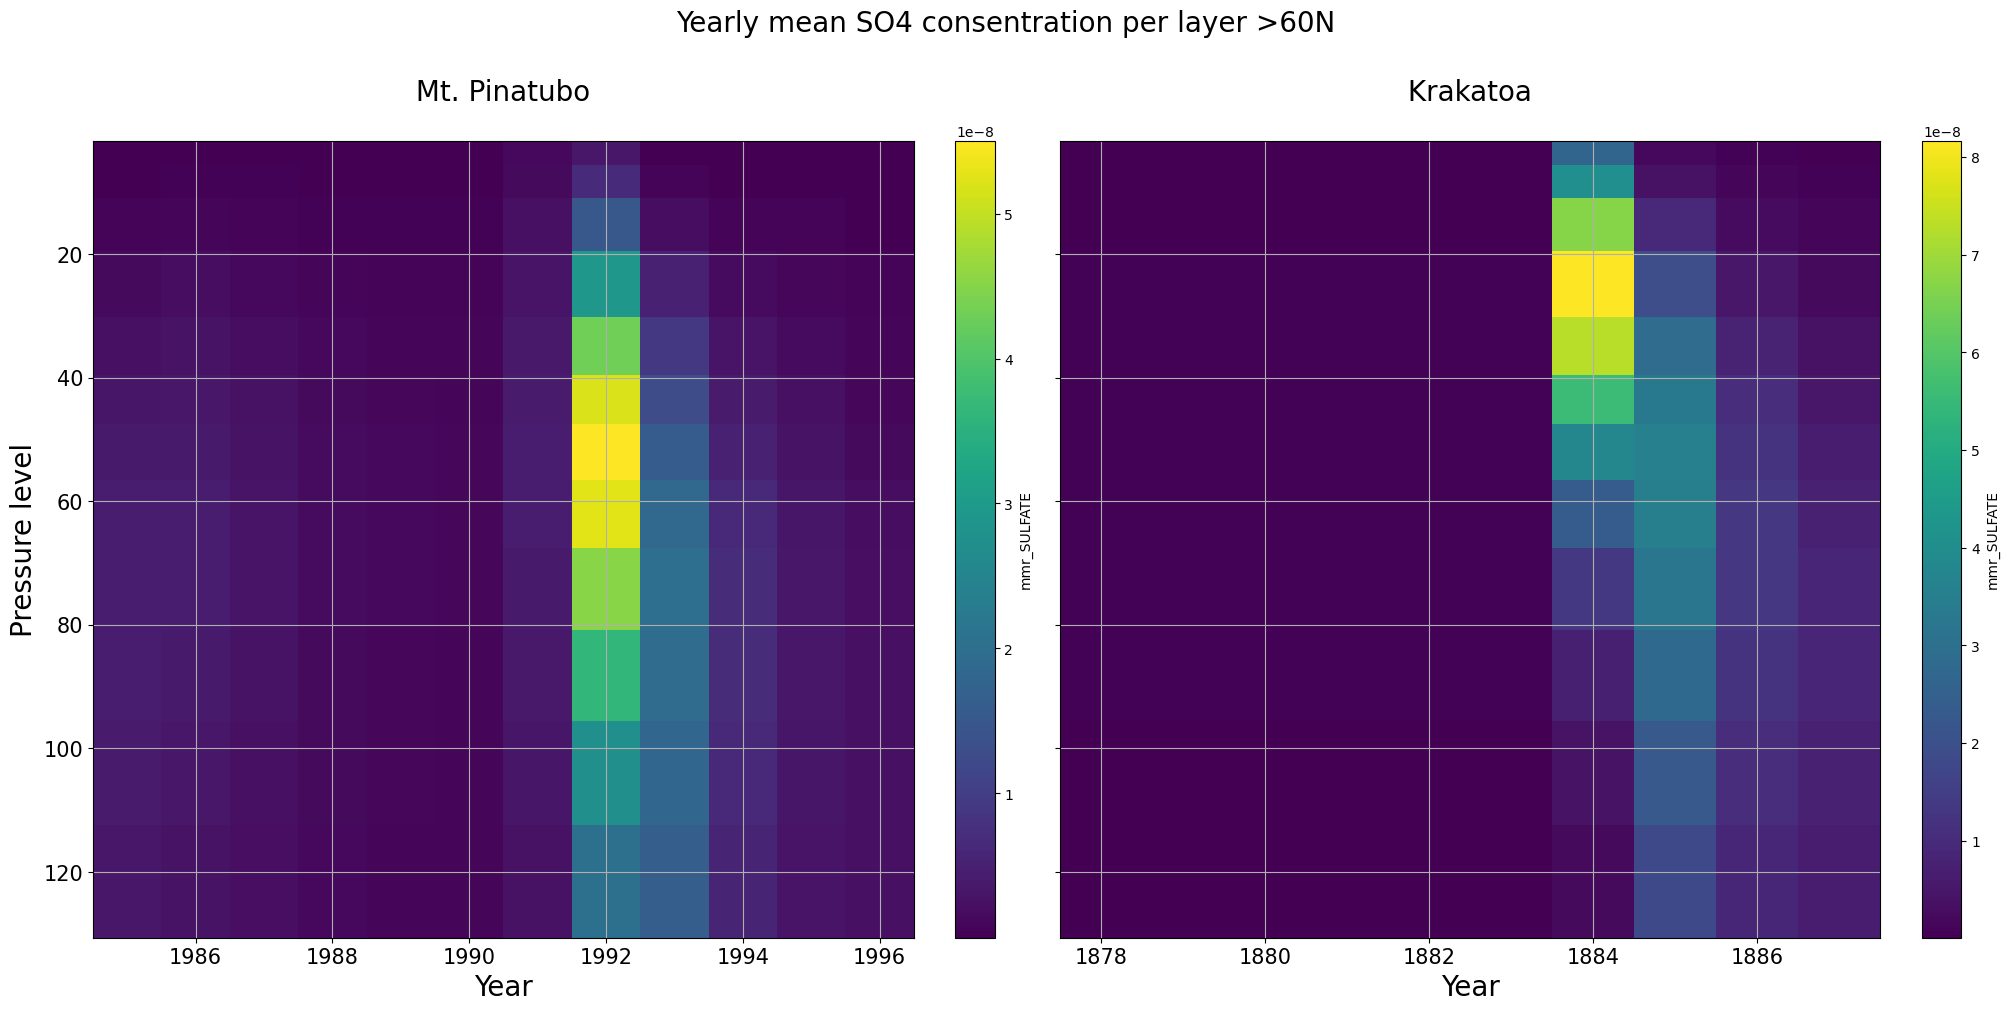

In [11]:
layers(annual_means_14,annual_means_pre)

Figure 2: Yearly mean SO4 consentration per layer. Only the upper 20 model layers shown.

SO4 aerosol particle maximum reaches higher into the atmosphere during the Krakatoa eruption compared to the eruption of Mt. Pinatubo. The aerosols released and produced by the eruption of Krakatoa in 1883 reach their maximum height at 24 hPa one year after the eruption, while for Mt. Pinatubo the particle max is at about 51 hPa. The aerosols does not appaer to have a longer life time than a few years in the upper modeled atmosphere.

In [12]:
do14 = xr.open_dataset(s3.open(o3_cb_14))
#do14.time.values;
ds1=do14['cb_O3']/(2.1415*(10**(-5)))

do16 = xr.open_dataset(s3.open(o3_cb_16))
ds2=do16['cb_O3']/(2.1415*(10**(-5)))

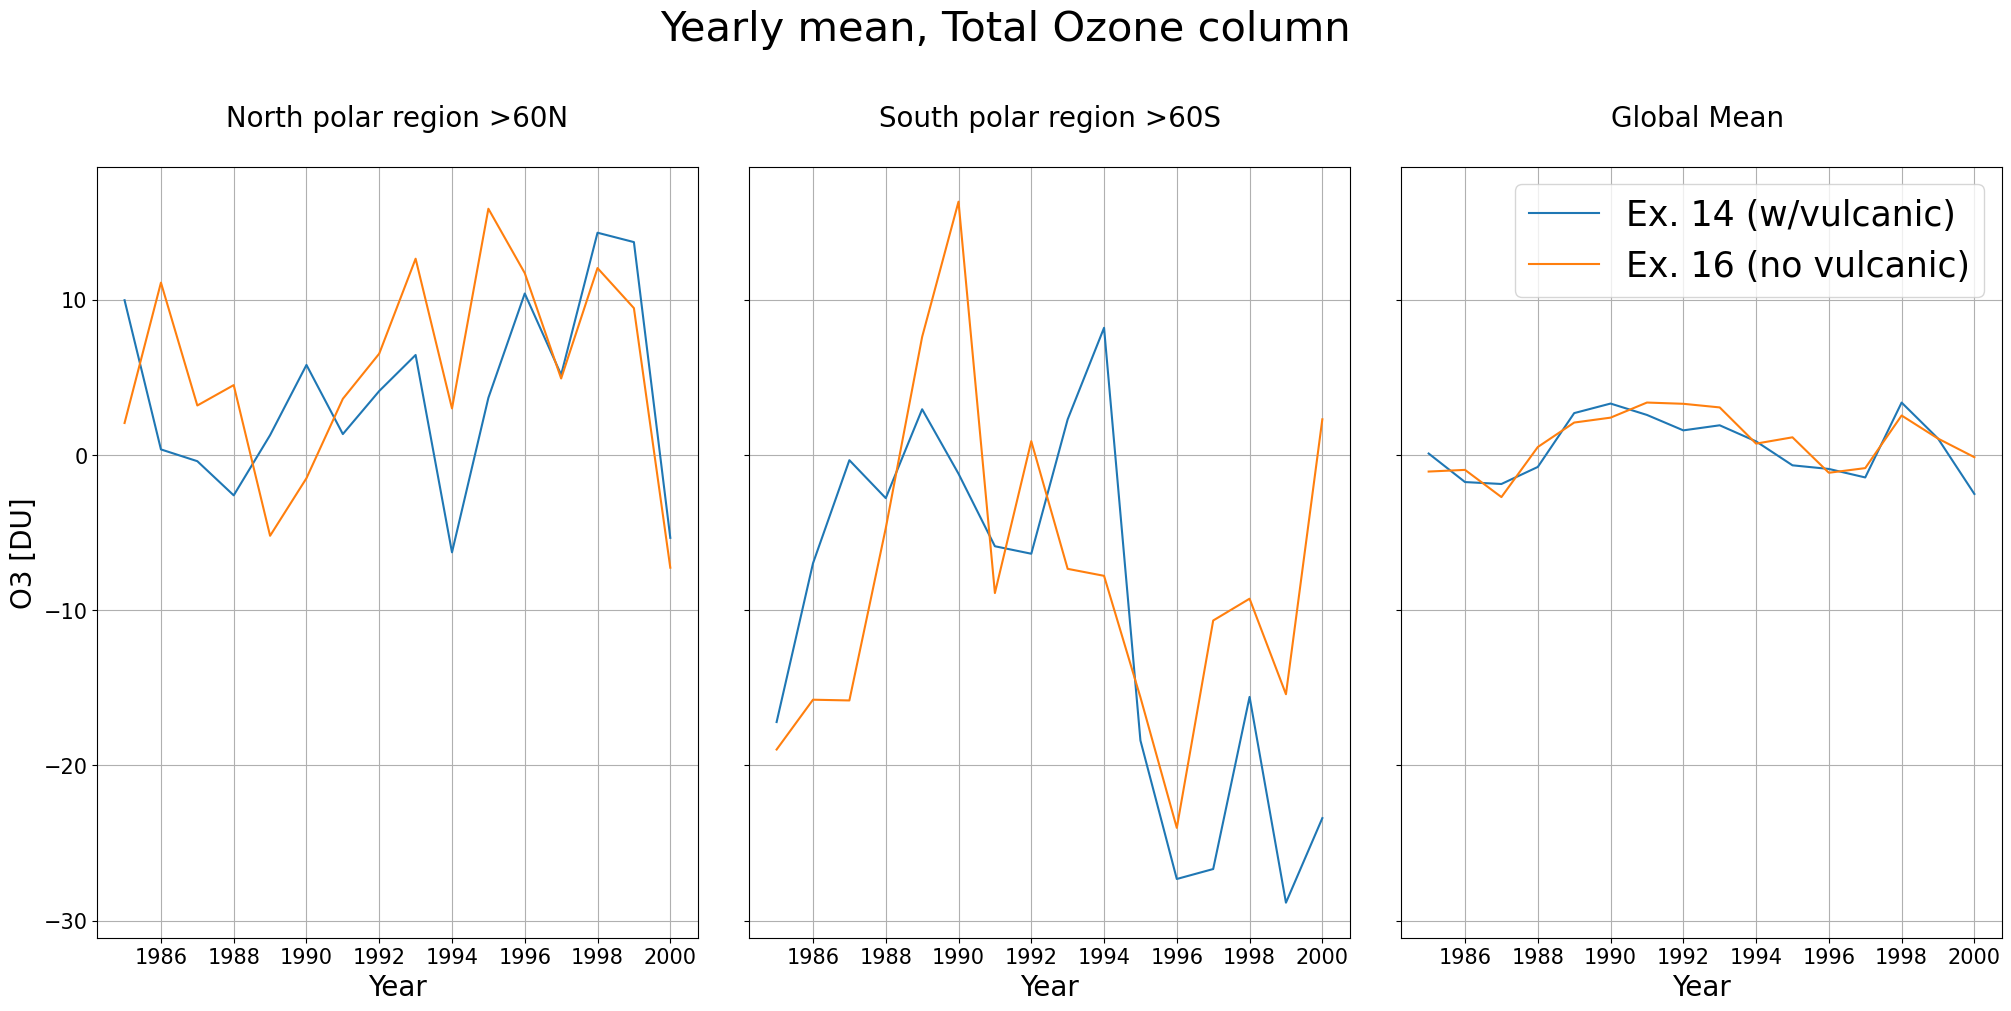

In [13]:
mean_plot_doub(ds1,ds2,1)

Figure 3: Yearly mean total ozone column for the two experimental rund around the Mt. Pinatubo eruption. 

Illustrated in figure number 3, it is hard to determine whether or not the model has an ozone response to the eruption of Mt. Pinatubo. The two experimental runs look strikingly similar even though one has no vulcanic forcing, and it is difficult to determine if a signal is a response or internal variability. In the global mean plot, one can see the two experiments crossing each other frequently, but after 1991 the experiment with vulcanic forcing has lower ozone values than the experiment without vulcanic forcing. Taking into consideration that this plot also shows responses to the 11-year solar cycle, it is uncertain if this is significant evidence of ozone response to vulcanic eruptions. 

In [14]:
dh = xr.open_dataset(s3.open(o3_cb_pre))
dh2=dh['cb_O3']/(2.1415*(10**(-5)))

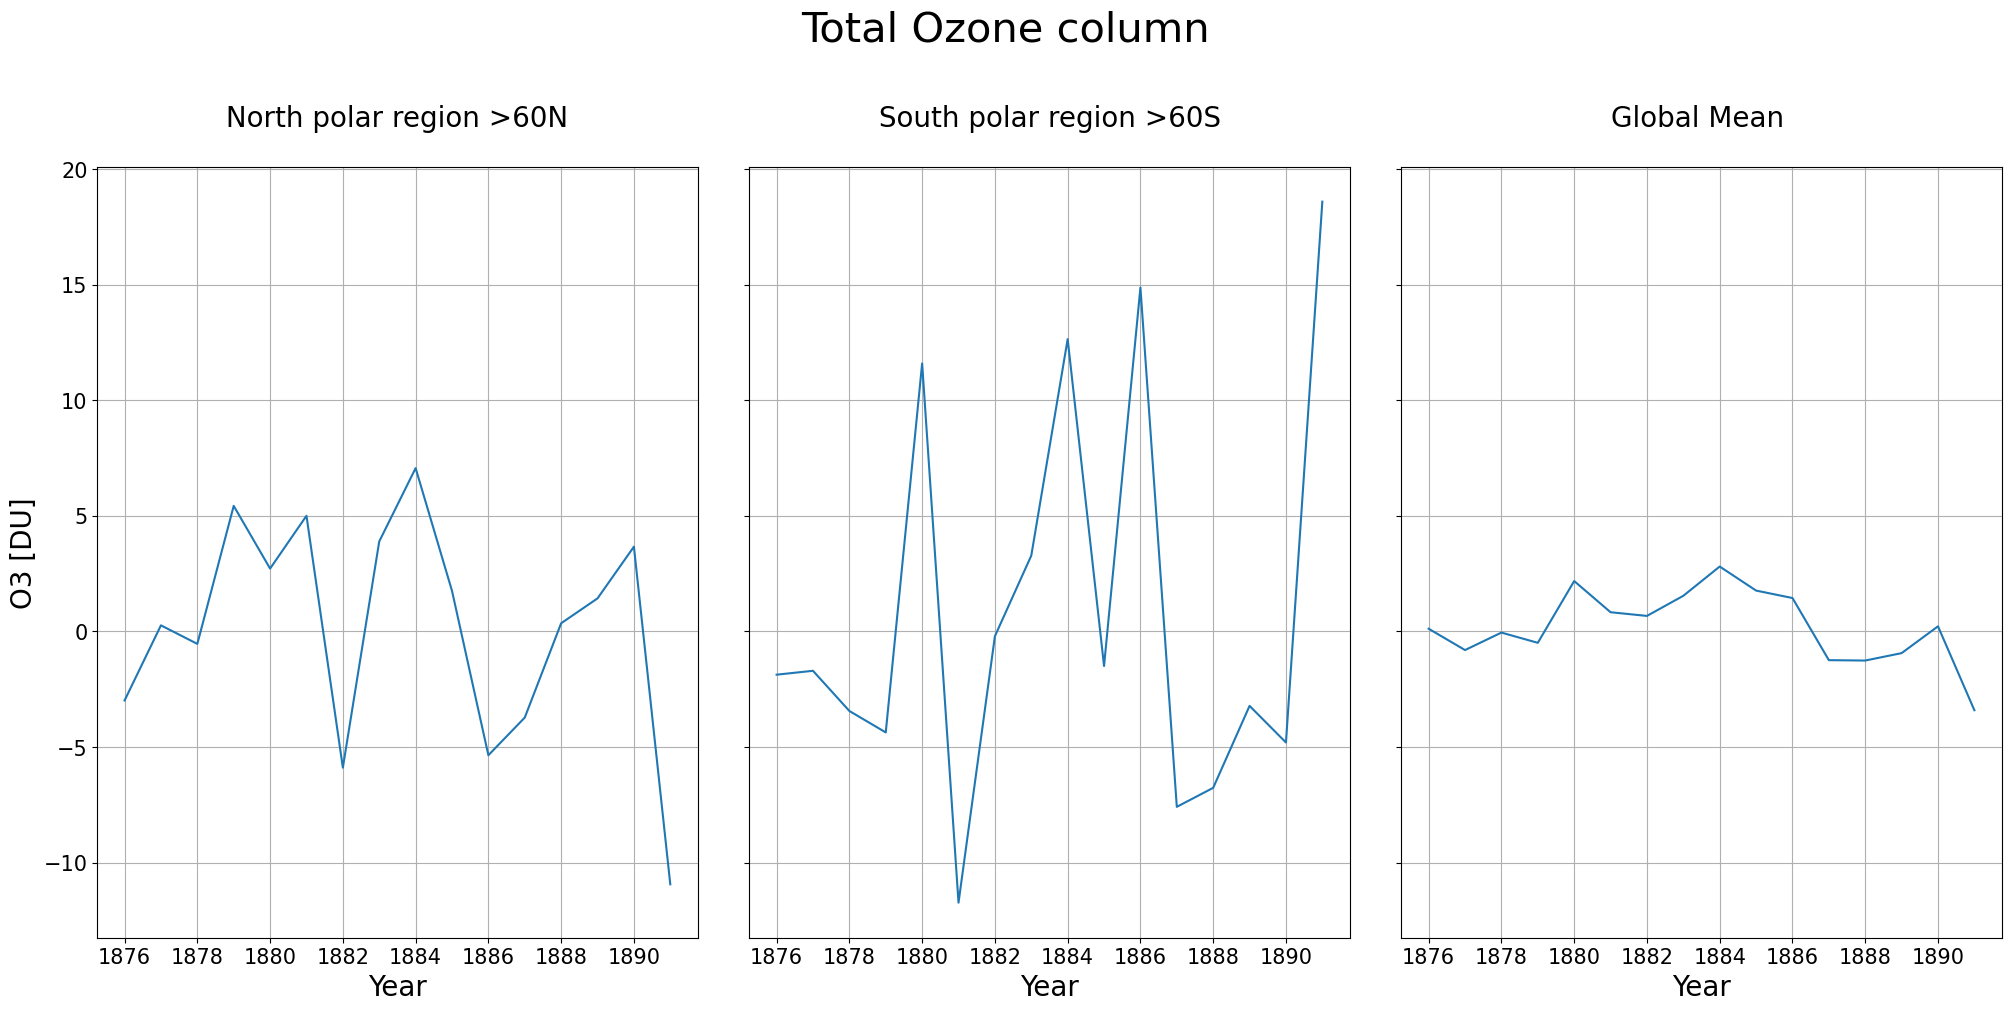

In [15]:
mean_plot_sing(dh2,2)

Figure 4: Yearly mean total ozone column for the Krakatao eruption. 

Figure 4 shows an increase in the total ozone column after the eruption of Krakatoa in 1883, across the polar regions and in the global mean. Assuming the increase in ozone is a response to vulcanic forcing the effect does not seem to be long-lasting considering the following years. 

Taking both figure 3 to figure 4 into account it is challenging to see any direct ozone response to vulcanic eruptions. 

In [16]:
dso3= xr.open_dataset(s3.open(o3_14))
ds_o3=dso3['O3']
dso3_lev_14=ds_o3.sel(lev=3, method='nearest').drop('lev')
dso3_lev_14_t=dso3_lev_14.sel(time=slice(start_pina,end_pina))

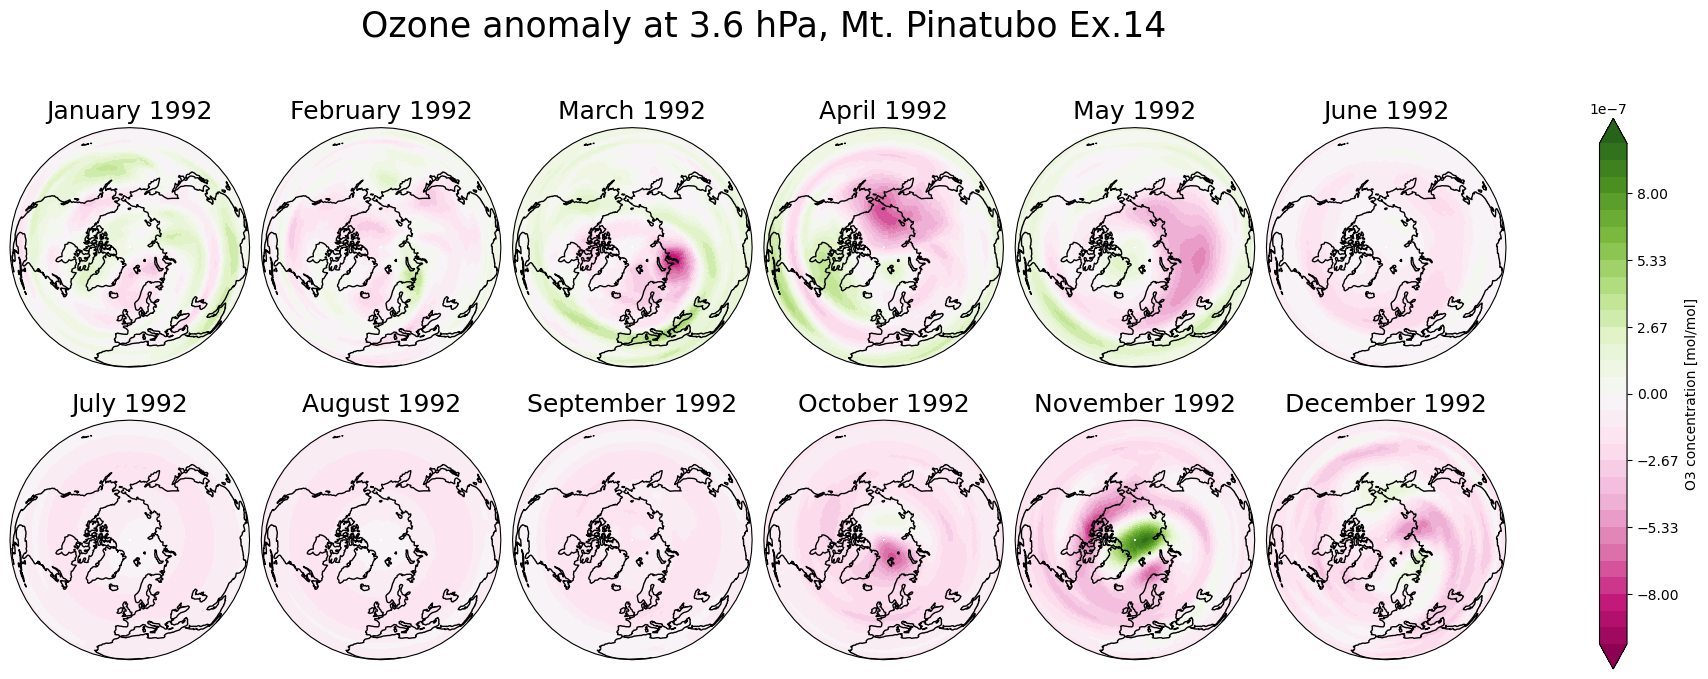

In [17]:
anom14=calc_monthly_anomaly(dso3_lev_14_t,1990)
north_multi_plot(anom14,1992,'PiYG','Ozone anomaly at 3.6 hPa, Mt. Pinatubo Ex.14')

Figure 5: Monthly anomaly spacial plot showing ozone consentration in the models ozone max layer. 

Mixed results can be interpreted form figure 5. Over all months there is a trend of ozone in the max layer is mainly negative post-eruption, although we see a positive anomaly early in 1992.

In [18]:
dso3_16= xr.open_dataset(s3.open(o3_16))
dso3=dso3_16['O3']
dso3_lev_16=dso3.sel(lev=3.6, method='nearest').drop('lev')
dso3_lev_16_t=dso3_lev_16.sel(time=slice(start_pina,end_pina))

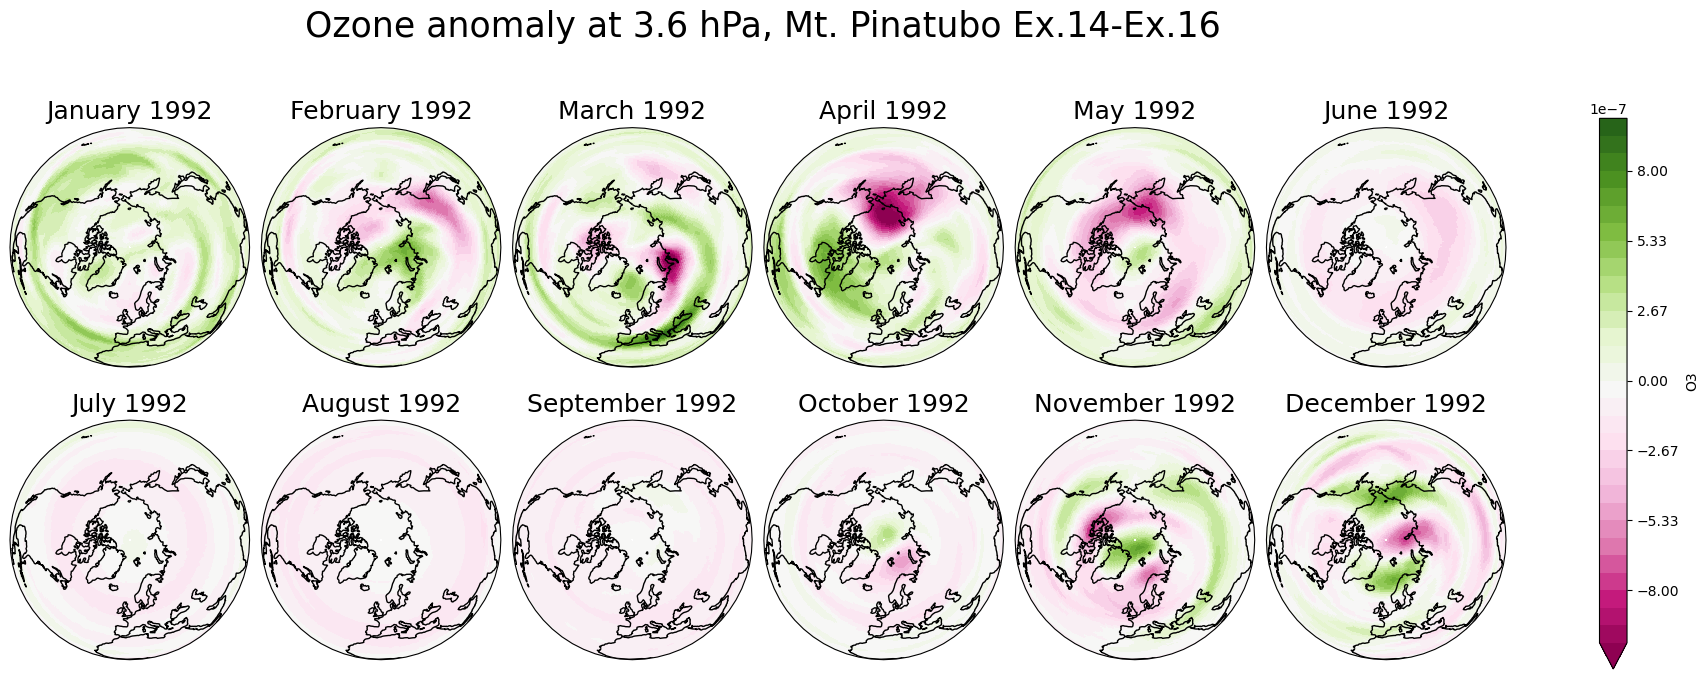

In [19]:
anom16=calc_monthly_anomaly(dso3_lev_16_t,1990)
anom_diff=anom14-anom16
north_multi_plot(anom_diff,1992,'PiYG','Ozone anomaly at 3.6 hPa, Mt. Pinatubo Ex.14-Ex.16')

Figure 6: Difference between the experiment with and without vulcanic forcing ilustrated by monthly anomaly spacial plot showing ozone consentration in the models ozone max layer. 

Figure 6 is in many ways similar to figure 5. We have positive ozone anomalies in the first months, but with increasing features of negative anomalies, especially near the north pole. summer and early autumn have a weak negative anomaly before the last months of the year again become quite mixed.

Compared to figure X (Have to find out where to put this plot, either in the methods as a part of the explanation why i use monthly climatologies and anomalies, or in supliments) which shows a clear seasonal cycle, the negative anomalies in February, March, and April defy the seasonal cycle and can possibly be a sign of a response to the Mt. Pinatubo volcanic eruption. A reason why the strong negative anomaly shows up mostly in spring can be because of solar radiation returning and initializing the ozone depletion on polar stratospheric clouds.

One explanation for why the response might not be as strong as anticipated might have something to do with the results from figure 2 which shows that the aerosols might not reach high enough altitude to form stratospheric clouds and affect the ozone layer.


In [20]:
dso3_pre= xr.open_dataset(s3.open(o3_pre))
dso3_pre.time.values;
dso3_p=dso3_pre['O3']
dso3_lev_pre=dso3_p.sel(lev=3.6, method='nearest').drop('lev')
dso3_lev_pre_t=dso3_lev_pre.sel(time=slice(start_krak,end_krak))

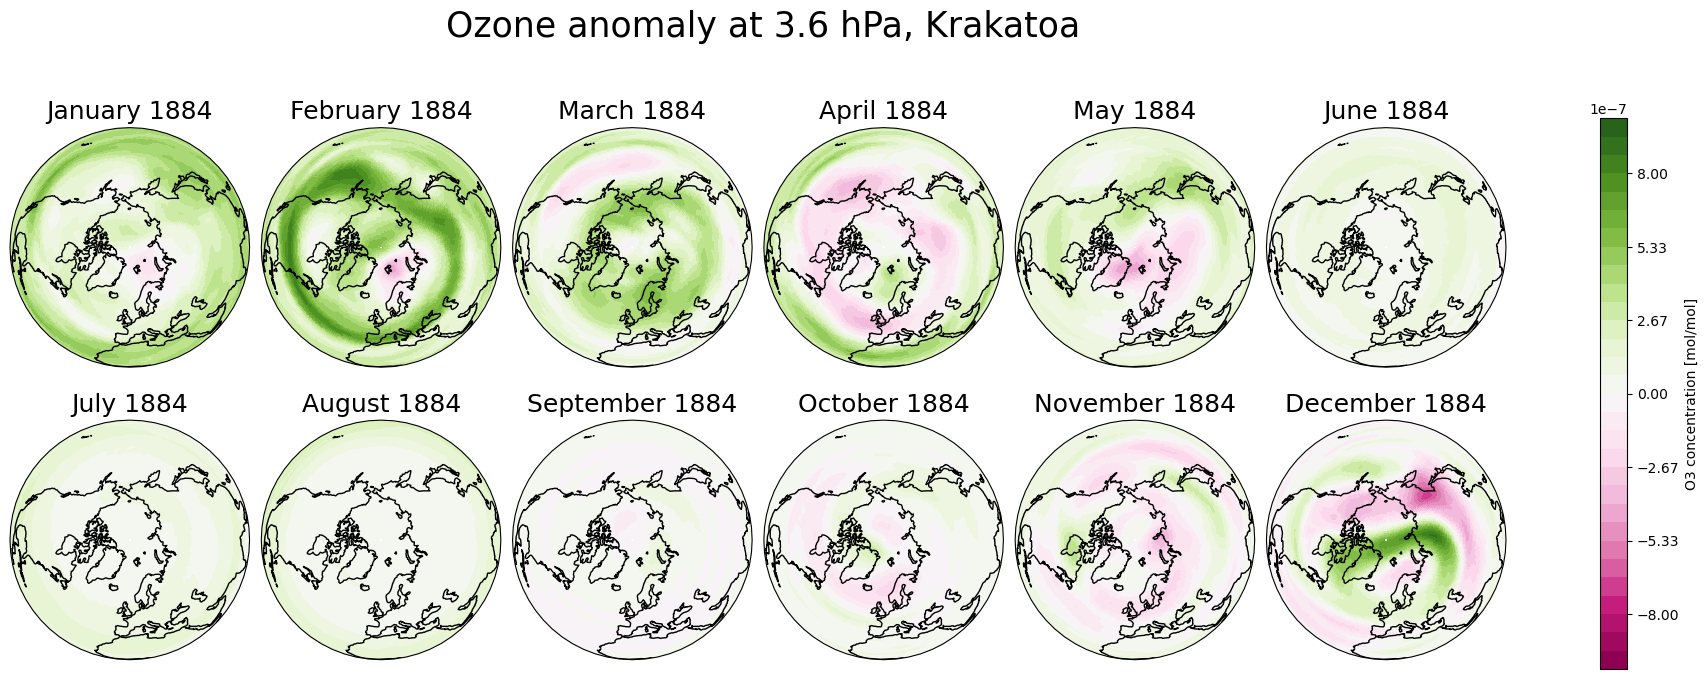

In [21]:
anompre=calc_monthly_anomaly(dso3_lev_pre_t,1884)
north_multi_plot(anompre,1884,'PiYG','Ozone anomaly at 3.6 hPa, Krakatoa')

Figure 7: Monthly anomaly spacial plot showing ozone consentration in the models ozone max layer. 

Taking into account what we learned from the difference between Figures 5 and 6, that subtracting the model experiment with no vulcanic forcing does not show that much of a difference, we can say the model shows a clear positive anomaly of ozone after the eruption of Krakatoa. In figure 6 one can see a positive ozone response across the board, especially in the earlier months of the year. 

As seen in figure 2 the SO4 AOD for Krakatoa reaches a higher level in the atmosphere than for Mt. Pinatubo. This might be a reason why figure 7 show a stronger positive response compared to figure 5 where the response is quite mixed.


### **4.0 Conclusion**

Whether or not NorESM has an ozone response to vulcanic eruptions is a difficult question to answer. If one focuses on the total column burden of ozone one might conclude that the model does not have an obvious response to vulcanic eruptions. When focusing on the ozone maximum layer and looking at it from a spatial perspective one can determine that when factoring out the seasonality there might be a response to vulcanic eruptions.

To answer the research questions and address the hypothesis; 
The ozone in NorESM responds to vulcanic eruptions through the formation of SO4 particles that provide a surface for which heterogeneous ozone-depleating reactions can take place. There is a difference in how the ozone responds depending on whether we have present-day or pre-CFC conditions. Even if the ozone response in present-day conditions can be difficult to properly determine from the results, the response in pre-CFC conditions is easier to spot though a model run without vulcanic forcing is needed to properly compare the two. 


### **5.0 Refrences**


(I need to go through and rewrite, write and add refrences to the whole report)

SPARC CCMVal (2010), SPARC Report on the Evaluation of Chemistry-Climate Models, V.
Eyring, T. G. Shepherd, D. W. Waugh (Eds.), SPARC Report No. 5, WCRP-132, WMO/TD-No.
1526, chapter 8, especially 8.8 Volcanic Aerosols.
(https://www.atmosp.physics.utoronto.ca/SPARC/ccmval_final/PDFs_CCMVal%20June%201
5/ch8.pdf)


### **Acknowledgments**
I would like to thank Emma and Zhihong for help.

### **Suplement**